In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import random


In [3]:
df = pd.read_csv("Credit Card Customer Data.csv")
# Clean column names
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Preview
df.head()

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


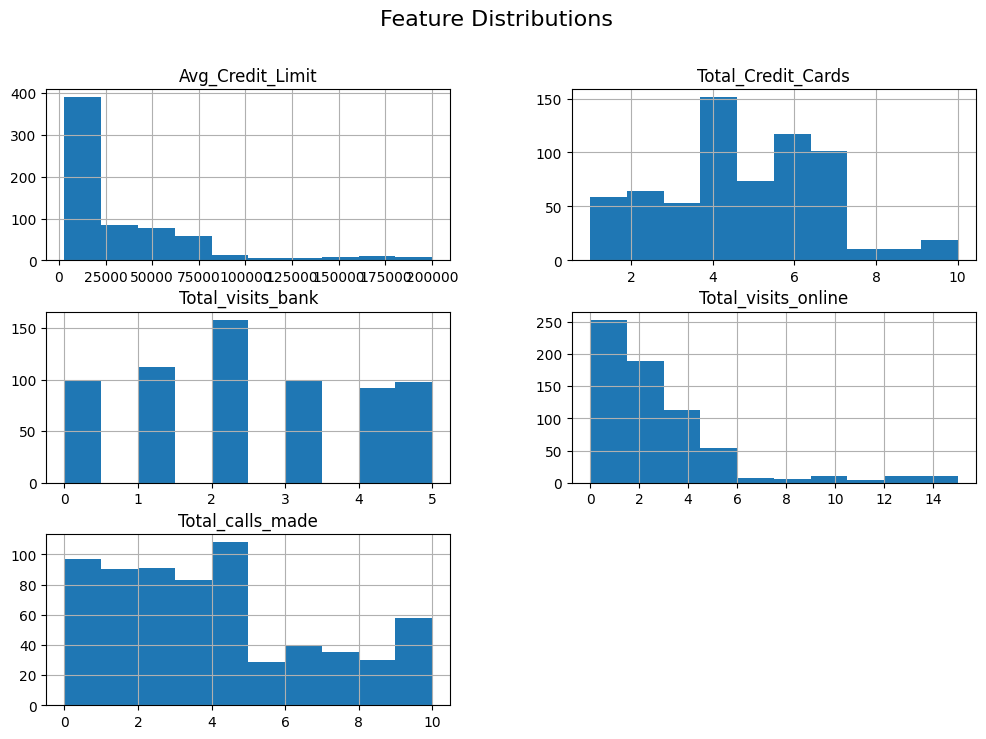

In [12]:
# Histograms
df[['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 
    'Total_visits_online', 'Total_calls_made']].hist(figsize=(12, 8))
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()




In [5]:
features = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 
            'Total_visits_online', 'Total_calls_made']
X = df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
def euclidean(a, b):
    return np.sqrt(np.sum((a - b)**2))

def kmeans(X, k, max_iters=100):
    centers = X[random.sample(range(len(X)), k)]
    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]
        for point in X:
            idx = np.argmin([euclidean(point, center) for center in centers])
            clusters[idx].append(point)
        new_centers = [np.mean(cluster, axis=0) if cluster else centers[i]
                       for i, cluster in enumerate(clusters)]
        if np.allclose(centers, new_centers):
            break
        centers = new_centers
    return centers, clusters


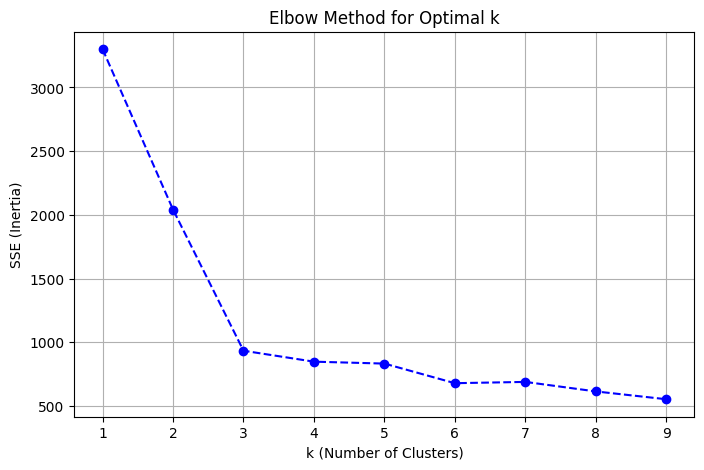

In [7]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    _, clusters = kmeans(X_scaled, k)
    sse = sum(np.sum((np.array(cluster) - np.mean(cluster, axis=0))**2)
              for cluster in clusters)
    inertia.append(sse)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo--')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [8]:
k_optimal = 3
centers, clusters = kmeans(X_scaled, k_optimal)

# Create cluster labels
labels = np.zeros(len(X_scaled))
for cluster_idx, cluster in enumerate(clusters):
    for point in cluster:
        idx = np.where((X_scaled == point).all(axis=1))[0][0]
        labels[idx] = cluster_idx

df['Cluster'] = labels.astype(int)


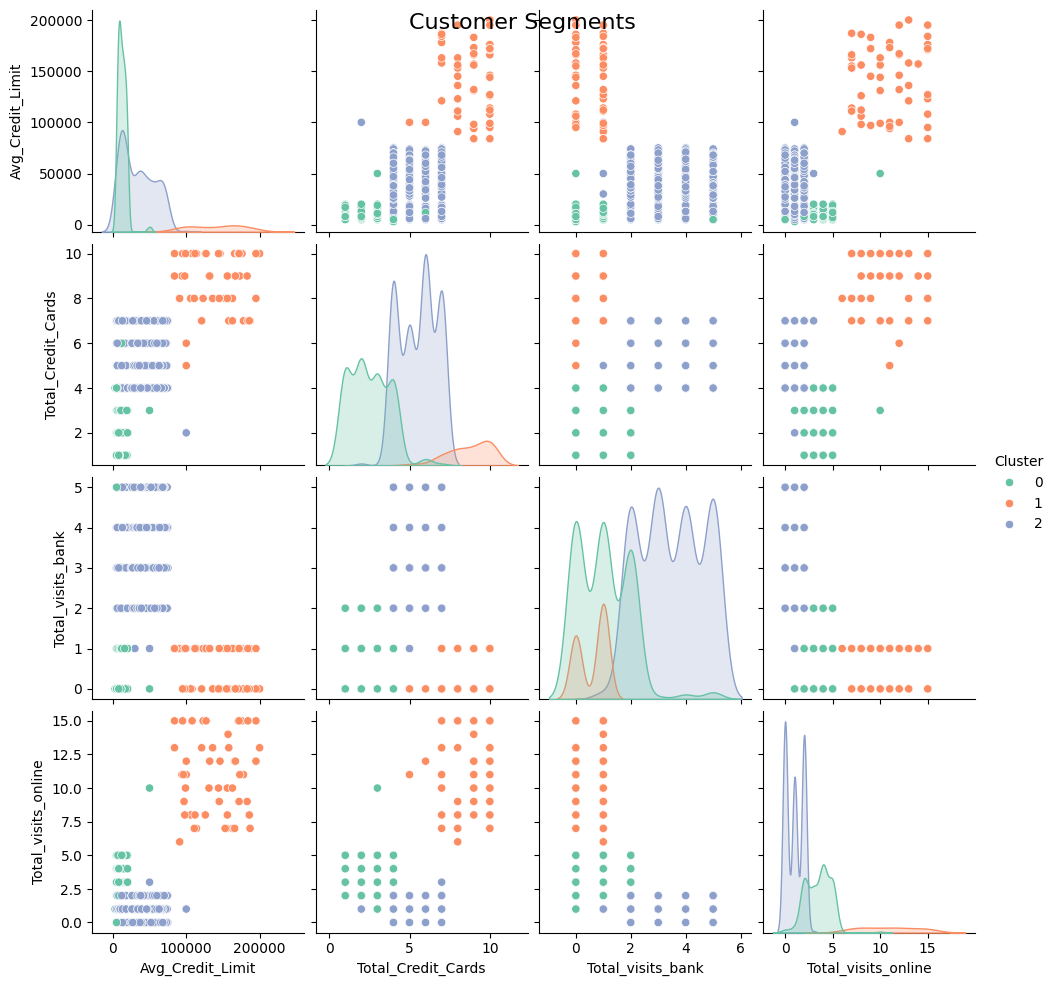

In [9]:
sns.pairplot(df, hue='Cluster', palette='Set2', 
             vars=['Avg_Credit_Limit', 'Total_Credit_Cards', 
                   'Total_visits_bank', 'Total_visits_online'])
plt.suptitle("Customer Segments", fontsize=16)
plt.show()


In [10]:
X_reg = df[['Total_Credit_Cards', 'Total_visits_bank', 
            'Total_visits_online', 'Total_calls_made']]
y_reg = df['Avg_Credit_Limit']

model = LinearRegression()
model.fit(X_reg, y_reg)
y_pred = model.predict(X_reg)


Mean Squared Error: 544315166.60
R-squared: 0.6149


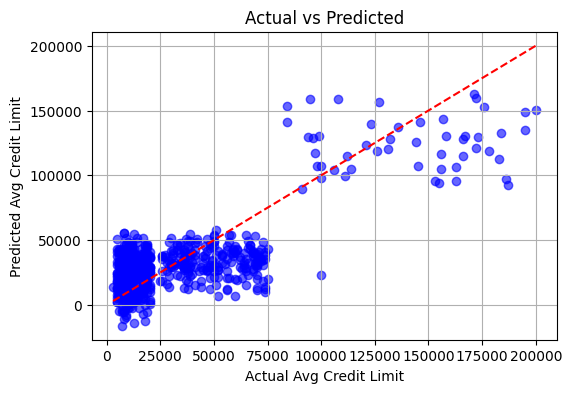

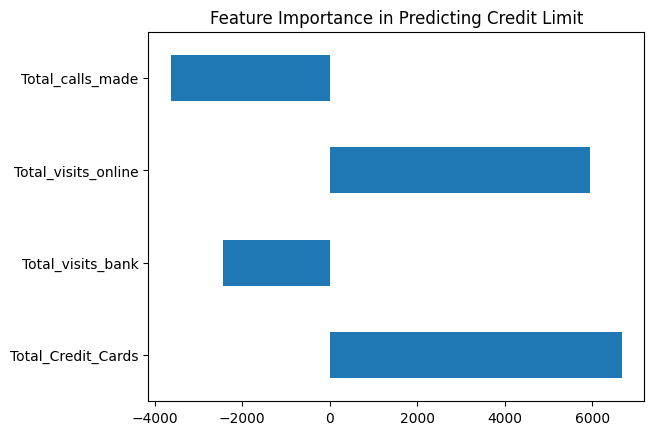

In [11]:
# Evaluation
mse = mean_squared_error(y_reg, y_pred)
r2 = r2_score(y_reg, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.4f}")

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_reg, y_pred, c='blue', alpha=0.6)
plt.plot([min(y_reg), max(y_reg)], [min(y_reg), max(y_reg)], 'r--')
plt.xlabel("Actual Avg Credit Limit")
plt.ylabel("Predicted Avg Credit Limit")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

# Feature importance
importance = pd.Series(model.coef_, index=X_reg.columns)
importance.plot(kind='barh')
plt.title("Feature Importance in Predicting Credit Limit")
plt.show()
